# Modelo Económico Piloto Industrial C3 AI

## Objetivo

Estimar el **beneficio económico** del piloto de Optimización de Procesos **(PrO)** de C3 AI, por medio del uso de KPI's de proceso que se impactan en el proceso de optimización.
Este optimizador tiene alcance en los siguientes procesos industriales:
- Extracción de Jugo
- Clarificación de Jugo
- Evaporación de Jugo
- Centrífugas

El objetivo del optimizador es recomendar los valores de variables de decisión en estos procesos que *maximicen la cantidad de azúcar recuperada*.

Dado que **el objetivo del optimizador es reemplazar las decisiones operativas humanas**, al momento de adoptarlo se pierde la línea base que sirve para comparar. Por este motivo se seleccionó un proceso de **back-testing** para explicar (durante un período en el que el optimizador no operó) *qué hubiera ocurrido si las recomendaciones del optimizador se hubieran seguido*, y por lo tanto la línea base se convierte en el desempeño real del proceso en el pasado. Este es un ejercicio teórico que se vale de los modelos predictivos que se desarrollaron para las funciones objetivo del optimizador. 

***La diferencia entre la línea base y el escenario hipotético del optimizador sirve para estimar el beneficio debido al uso del optimizador.***

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Resultados Back-Testing

In [3]:
# .csv de Resultados Back-Testing C3 AI PrO PSA
backtesting_data = pd.read_csv("zafra_2024_final_yield_benefit.csv")
backtesting_data.head()

,timestamp,Final_Yield_Benefit
0,2023-12-08 04:00:00,0.819271
1,2023-12-11 16:00:00,0.790421
2,2023-12-14 08:00:00,0.984876
3,2023-12-16 04:00:00,0.829951
4,2023-12-17 12:00:00,0.940674


![title](timeseries.png)

In [4]:
backtesting_data["Final_Yield_Benefit"].describe()

count    327.000000
mean       0.691402
std        0.155234
min        0.254976
25%        0.576799
50%        0.672735
75%        0.810293
max        1.097605
Name: Final_Yield_Benefit, dtype: float64

In [5]:
mu, sigma = backtesting_data["Final_Yield_Benefit"].mean(), backtesting_data["Final_Yield_Benefit"].std() # media y desviación estándar de beneficios

array([[<Axes: title={'center': 'Final_Yield_Benefit'}>]], dtype=object)

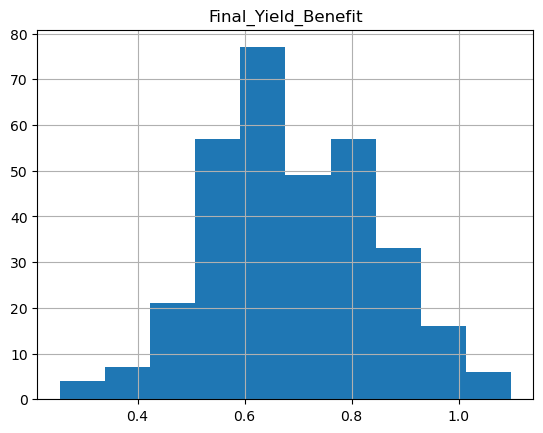

In [6]:
backtesting_data.hist()

## Estimación de Beneficios Promedios

#### KPI's de Caña de Azúcar
Se utilizan los siguientes KPI's de *Caña de Azúcar* entregada a PSA:
- Rendimiento Core Sampler (kg azúcar / t caña).
- Total de Caña Recibida en la Zafra (t caña).
- Dias de Zafra (dia).
- Beneficio Marginal por Tonelada de Azúcar que Margina (USD / t azúcar).
- Contenido de Melaza por Tonelada de Caña (%).
- Contenido de Melaza en Miel Final (%).

#### KPI's de Alcohol
Se utilizan los siguientes KPI's de *Producción del Alcohol* en BSA:
- Rendimiento teórico de Alcohol (l alcohol / t azúcar fermentable).
- Densidad del Alcohol (t alcohol / m3 alcohol).
- Eficiencia Promedio de Destilerías (%).
- Contenido Promedio de Azúcares Reductores en la Melaza (%).
- Beneficio Marginal del Alcohol que Margina (USD / m3 alcohol).

#### KPI's Piloto Industrial PSA
Los siguientes KPI's son impactados por el *piloto de optimización PrO*:
- Incremento en Rendimiento Industrial (%).
- Decremento en Azúcares Fermentables en Melaza (%).

### Estimación de Beneficios por Azúcar Adicional

Para estimar la cantidad de azúcar adicional se utiliza la siguiente ecuación:

$AzucarIndustrial_{Adicional} = RendimientoIndustrial_{Adicional}/100 * Caña_{optimizacion}*RendimientoCore/100$

Donde:

- $RendimientoIndustrial_{Adicional}$ es el incremento en Rendimiento Industrial por el optimizador.

- $ Caña_{optimizacion} = DiasEfectivosOptimizador * RatioMolienda$ es la estimación de caña que se estima procesar utilizando el optimizador.
- $ RatioMolienda = TotalCaña / DiasZafra$ es el Ratio de Molienda promedio (t caña / dia).

Finalmente para estimar el beneficio económico se utiliza la siguiente ecuación:

- $Beneficio_{Azucar} = BeneficioMarginal_{Azucar} * AzucarIndustrial_{Adicional}$



In [7]:
# KPI's
Rend_Ind_Ad = 0.691402
Rend_Core = 128.58
Dias_Opt = 100
Dias_Zafra = 183
Total_Caña = 4767135.73
Ben_Marginal_Az = 467.06

#Variables
Ratio_Molienda = Total_Caña / Dias_Zafra
Caña_opt = Dias_Opt * Ratio_Molienda

# Beneficio
Az_Ind_Ad = Rend_Ind_Ad / 100 * Caña_opt * Rend_Core / 1000
Ben_Az_Ad = Ben_Marginal_Az * Az_Ind_Ad

print("Azúcar Industrial Adicional (toneladas): %.2f" % Az_Ind_Ad)
print("Beneficio Total Azúcar Adicional (USD): %.2f" % Ben_Az_Ad)

Azúcar Industrial Adicional (toneladas): 2315.85
Beneficio Total Azúcar Adicional (USD): 1081641.04


### Estimación de Costos de Oportunidad en Alcohol

Para estimar la cantidad de Alcohol impactada se utiliza las siguientes ecuaciones:

$AFMelaza = (SacarosaMelaza + ARMelaza)/100$

$RendIndAlcohol = AFMelaza*RendTeoricoAF*(EffDestilerias/100)/DensidadAlcohol$

$RendIndAlcohol_{Optimizador} = AFMelaza_{optimizador}*RendTeoricoAF*EffDestilerias/100)/DensidadAlcohol$

$AlcoholIndustrial_{Adicional} = Caña_{optimizacion}*(Melaza_{Caña}/100)*AFMelaza_{optimizador}*RendIndAlcohol_{Optimizador}/1000 - Caña_{optimizacion}*(Melaza_{Caña}/100)*AFMelaza*RendIndAlcohol/1000$


Donde:

- $AFMelaza$ es el contenido promedio de azúcares fermentables en la melaza (%).
- $SacarosaMelaza$ es el contenido promedio de sacarosa en la melaza (%).
- $ARMelaza$ es el contenido promedio de azúcares reductores en la melaza (%).
- $RendIndAlcohol$ es el rendimiento industrial de alcohol (m3 alcohol / t melaza).
- $RendIndAlcohol_{Optimizador}$ es el rendimiento industrial de alcohol usando el optimizador (m3 alcohol / t melaza).
- $RendTeoricoAF$ es el rendimiento teórico de alcohol con azúcar fermentable (m3 alcohol/ t azúcar fermentable).
- $EffDestilerias$ es la eficiencia promedio de las destilerías (%).
- $DensidadAlcohol$ es la densidad del alcohol (t alcohol / m3 alcohol).
- $AlcoholIndustrial_{Adicional}$ es el incremento en Rendimiento Industrial por el optimizador.
- $Caña_{optimizacion} = DiasEfectivosOptimizador * RatioMolienda$ es la estimación de caña que se estima procesar utilizando el optimizador.
- $Melaza_{Caña}$ es el contenido promedio de melaza en la caña (%).
- $AFMelaza_{optimizador}$ es el contenido promedio esperado de azúcares fermentables en la melaza (%) al utilizar el optimizador.


Finalmente para estimar el beneficio económico se utiliza la siguiente ecuación:

- $Beneficio_{Alcohol} = BeneficioMarginal_{Alcohol} * AlcoholIndustrial_{Adicional}$


### *Nota*
El estado actual del optimizador no contempla el proceso de *cristalización*, por lo cual no se tienen impactos directos sobre la cantidad de sacarosa en la melaza. Por este motivo se usa un valor de cero en el decremento (incremento) de sacarosa en la melaza.

In [8]:
# KPI's
Melaza_Caña = 4.608
Sacarosa_Melaza = 32.24
AR_Melaza = 8.84
Eff_Destilerias = 86.46
Rend_Teorico_AF = 0.511
Densidad_Alcohol = 0.789
Inc_Sacarosa_Melaza_Opt = 0
Ben_Marginal_Al = 9.88

# Variables
AF_Melaza = Sacarosa_Melaza + AR_Melaza
AF_Melaza_Opt = AF_Melaza + Inc_Sacarosa_Melaza_Opt
Rend_Ind_Alcohol = (AF_Melaza / 100) * Rend_Teorico_AF * (Eff_Destilerias/100) / Densidad_Alcohol
Rend_Ind_Alcohol_Opt = (AF_Melaza_Opt / 100) * Rend_Teorico_AF * (Eff_Destilerias/100) / Densidad_Alcohol


# Beneficio
Al_Ind_Ad = Caña_opt * Melaza_Caña/100 * AF_Melaza_Opt/100 * Rend_Ind_Alcohol_Opt - Caña_opt * Melaza_Caña/100 * AF_Melaza/100 * Rend_Ind_Alcohol
Ben_Al_Ad = Ben_Marginal_Al * Al_Ind_Ad
print("Alcohol Industrial Adicional (m3): %.2f" % Al_Ind_Ad)
print("Beneficio Total Alcohol Adicional (USD): %.2f" % Ben_Al_Ad)

Alcohol Industrial Adicional (m3): 0.00
Beneficio Total Alcohol Adicional (USD): 0.00


### Beneficio Económico Total
Se suman los beneficios por azúcar y alcohol.

$Beneficio_{Total} = Beneficio_{Azucar} + Beneficio_{Alcohol}$

In [9]:
Ben_Total = Ben_Az_Ad + Ben_Al_Ad
print("Beneficio Total (USD): %.2f" % Ben_Total)

Beneficio Total (USD): 1081641.04


## Estimación de Beneficios Probabilísticos
Se considera la naturaleza probabilística de los resultados del optimizador para simular la distribución resultante de los beneficios.

In [10]:
# Función de Beneficio Económico con Parámetros Teóricos de Mejora por el Optimizador
def beneficio_economico(incremento_rendimiento_azucar, incremento_sacarosa_melaza):

    # Beneficio
    Az_Ind_Ad = incremento_rendimiento_azucar / 100 * Caña_opt * Rend_Core / 1000
    Ben_Az_Ad = Ben_Marginal_Az * Az_Ind_Ad

    Al_Ind_Ad = Caña_opt * Melaza_Caña/100 * AF_Melaza_Opt/100 * Rend_Ind_Alcohol_Opt - Caña_opt * Melaza_Caña/100 * AF_Melaza/100 * Rend_Ind_Alcohol
    Ben_Al_Ad = Ben_Marginal_Al * Al_Ind_Ad

    Ben_Total = Ben_Az_Ad + Ben_Al_Ad

    return Ben_Total
    

In [11]:
beneficio_economico(0.691402,0)

1081641.0361319408

### Simulación
Se realiza una simulación de Monte Carlo dada la naturaleza probabilística del beneficio del optimizador.

In [12]:
# muestreo
n_simulations = 1000
l_xs = []
l_ys = []

# simulaciones
for _ in range(n_simulations):
    
    # rend_azucar se muestrea aleatoriamente con una distribución normal con media mu y desviación estándar sigma
    x = np.random.normal(mu, sigma)
    l_xs.append(x)
    
    # rend_alcohol se muestrea aleatoriamente con una distribución uniforme entre 0 y 0 (no se usa en el estado actual del optimizador)
    y = np.random.uniform(0, 0)
    l_ys.append(y)

In [13]:
# evaluación
l_bs = []
for i in range(n_simulations):
    
    # beneficios económicos de la muestra
    beneficios = beneficio_economico(l_xs[i],l_ys[i])
    l_bs.append(beneficios)

In [14]:
# Dataframe de Simulaciones

# listas de simulación
inc_rend_azucar = l_xs
inc_sacarosa_melaza = l_ys
beneficio = l_bs
 
# diccionario de listas
dict = {'Incremento Recuperación Azúcar (%)': inc_rend_azucar, 'Incremento Sacarosa en Melaza (%)': inc_sacarosa_melaza, 'Beneficio Económico (USD)': beneficio} 

# dataframe final
df = pd.DataFrame(dict)
df

,Incremento Recuperación Azúcar (%),Incremento Sacarosa en Melaza (%),Beneficio Económico (USD)
0,0.650689,0.0,1.017949e+06
1,0.951387,0.0,1.488366e+06
2,0.739727,0.0,1.157242e+06
3,0.498487,0.0,7.798411e+05
4,0.856180,0.0,1.339423e+06
...,...,...,...
995,0.758306,0.0,1.186307e+06
996,0.737782,0.0,1.154199e+06
997,0.924573,0.0,1.446418e+06
998,0.751673,0.0,1.175930e+06


array([[<Axes: title={'center': 'Incremento Recuperación Azúcar (%)'}>,
        <Axes: title={'center': 'Incremento Sacarosa en Melaza (%)'}>],
       [<Axes: title={'center': 'Beneficio Económico (USD)'}>, <Axes: >]],
      dtype=object)

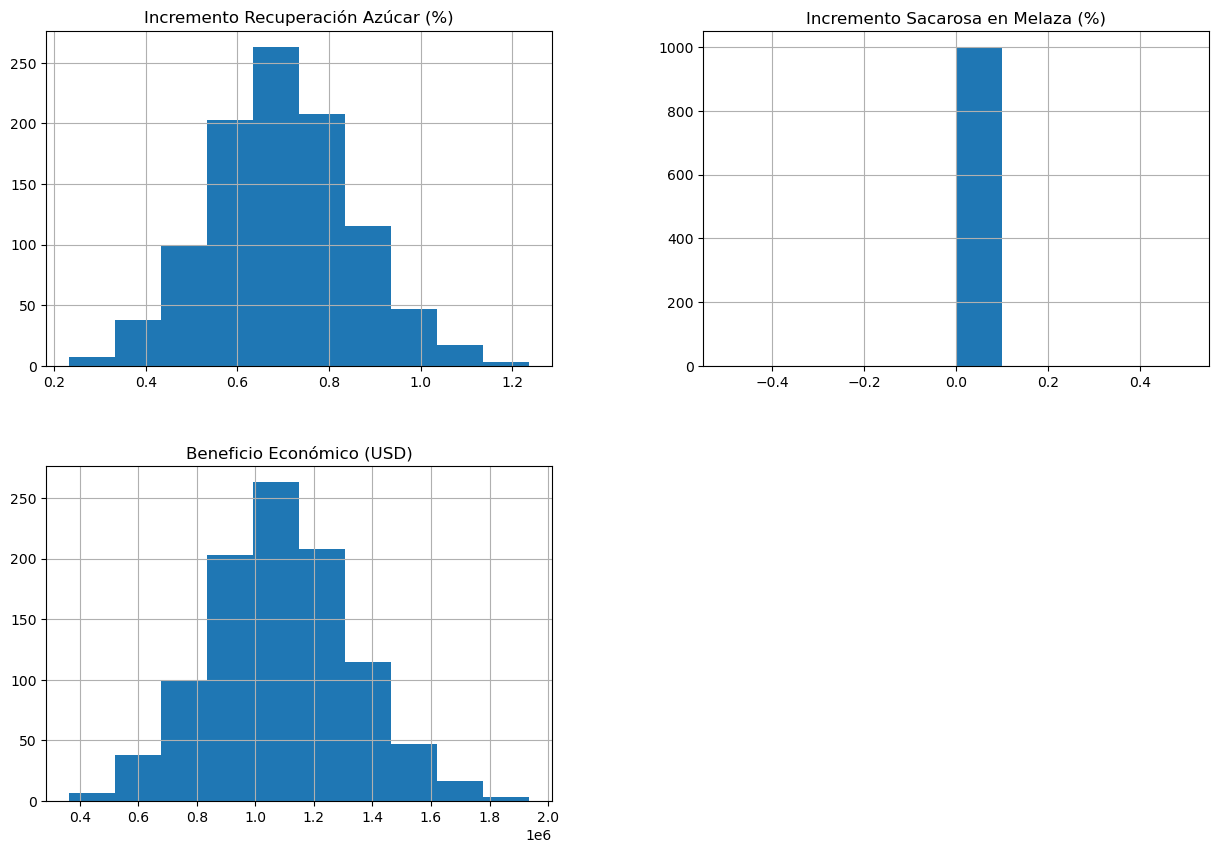

In [15]:
df.hist(figsize=(15,10))

In [16]:
df['Beneficio Económico (USD)'].describe()

count    1.000000e+03
mean     1.088786e+06
std      2.433010e+05
min      3.642094e+05
25%      9.288028e+05
50%      1.078753e+06
75%      1.242289e+06
max      1.934199e+06
Name: Beneficio Económico (USD), dtype: float64